In [1]:
from torch_geometric.datasets import MoleculeNet
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import matplotlib.pyplot as plt
import py3Dmol

# Load MoleculeNet dataset
dataset = MoleculeNet(root="data/MoleculeNet", name="Tox21")

# Extract the SMILES strings from the dataset (Tox21 contains SMILES in `smiles` attribute)
smiles_list = dataset.data.smiles  # SMILES strings are typically in this field

# Process the first molecule
example_index = 1
smiles = smiles_list[example_index]
print(f"SMILES String: {smiles}")

# Convert SMILES to RDKit molecule
mol = Chem.MolFromSmiles(smiles)


Extracting data/MoleculeNet/tox21/raw/tox21.csv.gz
Processing...
/home/linuxcat/anaconda3/envs/GM_2/lib/python3.9/site-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'NC(=O)NC1N=C(O[AlH3](O)O)NC1=O' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/home/linuxcat/anaconda3/envs/GM_2/lib/python3.9/site-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'O=CO[AlH3](OC=O)OC=O' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/home/linuxcat/anaconda3/envs/GM_2/lib/python3.9/site-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'CC(=O)O[AlH3](O)O' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/home/linuxcat/anaconda3/envs/GM_2/lib/python3.9/site-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'CC(=O)O[AlH3](O)OC(C)=O' sin

SMILES String: CCN1C(=O)NC(c2ccccc2)C1=O


Done!
/home/linuxcat/anaconda3/envs/GM_2/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


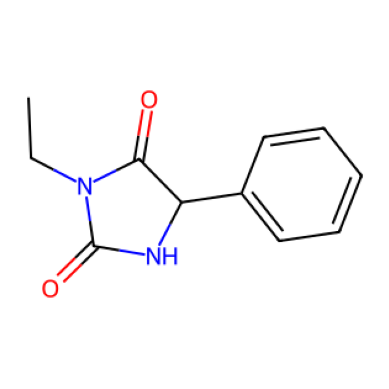

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [2]:
# Generate 2D Coordinates
AllChem.Compute2DCoords(mol)

# Visualize as a 2D Molecule
img = Draw.MolToImage(mol, size=(300, 300))
plt.imshow(img)
plt.axis('off')
plt.show()

# Generate 3D Coordinates
mol_3d = Chem.AddHs(mol)  # Add hydrogens for 3D structure
AllChem.EmbedMolecule(mol_3d, AllChem.ETKDG())  # Generate 3D conformation

# Visualize as a 3D Molecule using py3Dmol
block = Chem.MolToMolBlock(mol_3d)
view = py3Dmol.view(width=400, height=400)
view.addModel(block, "mol")  # Add the molecule
view.setStyle({"stick": {}})  # Style as sticks
view.zoomTo()  # Zoom to fit
view.show()

In [3]:
# Import required libraries
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score

# Load MoleculeNet dataset (Tox21)
dataset = MoleculeNet(root="data/MoleculeNet", name="Tox21")
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_node_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: Tox21(7823)
Number of graphs: 7823
Number of features: 9
Number of classes: 12


In [4]:
# Split dataset into train, validation, and test sets
torch.manual_seed(42)
train_dataset = dataset[:int(len(dataset) * 0.8)]
val_dataset = dataset[int(len(dataset) * 0.8):int(len(dataset) * 0.9)]
test_dataset = dataset[int(len(dataset) * 0.9):]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Import required libraries
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score

# Define the GIN (Graph Isomorphism Network) model
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super(GIN, self).__init__()
        self.convs = torch.nn.ModuleList()        # List to hold GINConv layers
        self.batch_norms = torch.nn.ModuleList()  # List to hold BatchNorm layers
        
        # Input GINConv layer with learnable ε
        self.convs.append(
            GINConv(
                torch.nn.Sequential(
                    Linear(in_channels, hidden_channels),  # Linear transformation
                    torch.nn.ReLU(),                      # Non-linearity
                    Linear(hidden_channels, hidden_channels)  # Another linear transformation
                ),
                train_eps=True  # Learnable epsilon parameter
            )
        )
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))  # Batch normalization
        
        # Hidden GINConv layers with learnable ε
        for _ in range(num_layers - 1):
            self.convs.append(
                GINConv(
                    torch.nn.Sequential(
                        Linear(hidden_channels, hidden_channels),
                        torch.nn.ReLU(),
                        Linear(hidden_channels, hidden_channels)
                    ),
                    train_eps=True
                )
            )
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))
        
        # Output fully connected layer
        self.fc = Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)  # Dropout for regularization
    
    def forward(self, x, edge_index, batch):
        # Pass through each GINConv + BatchNorm + ReLU + Dropout
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = conv(x, edge_index)
            x = batch_norm(x)
            x = F.relu(x)
            x = self.dropout(x)
        
        x = global_mean_pool(x, batch)  # Pool node features to graph-level representation
        x = self.fc(x)                  # Final linear layer for output
        return x


In [ ]:
# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model = GIN(
    in_channels=dataset.num_node_features,   # Number of input node features
    hidden_channels=64,                      # Hidden layer size
    out_channels=dataset.num_classes,        # Number of output classes
    num_layers=3,                            # Number of GIN layers
    dropout=0.5                              # Dropout rate
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
criterion = torch.nn.BCEWithLogitsLoss()                    # Binary cross-entropy loss for multi-label classification

# Training function
def train():
    model.train()  # Set model to training mode
    total_loss = 0
    for data in train_loader:  # Iterate over training batches
        data = data.to(device)
        data.x = data.x.float()
        data.y = data.y.float()
        
        # Mask valid labels (non-NaN)
        mask = ~torch.isnan(data.y)
        optimizer.zero_grad()  # Reset gradients
        
        out = model(data.x, data.edge_index, data.batch)  # Forward pass
        loss = criterion(out[mask], data.y[mask])         # Compute loss only on valid labels
        loss.backward()                                   # Backpropagation
        optimizer.step()                                  # Update parameters
        total_loss += loss.item()
    return total_loss / len(train_loader)                 # Return average loss

# Evaluation function
def evaluate(loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():  # Disable gradient computation
        for data in loader:  # Iterate over batches
            data = data.to(device)
            data.x = data.x.float()
            data.y = data.y.float()
            
            # Mask valid labels (non-NaN)
            mask = ~torch.isnan(data.y)
            out = model(data.x, data.edge_index, data.batch)  # Forward pass
            loss = criterion(out[mask], data.y[mask])         # Compute loss
            total_loss += loss.item()
            
            y_true.append(data.y[mask].cpu())                 # Store true labels
            y_pred.append(out[mask].cpu())                    # Store predictions
    
    y_true = torch.cat(y_true, dim=0)                         # Concatenate all true labels
    y_pred = torch.cat(y_pred, dim=0)                         # Concatenate all predictions
    
    # Compute ROC-AUC score for multi-label classification
    roc_auc = roc_auc_score(y_true.numpy(), y_pred.sigmoid().numpy(), average="macro")
    return total_loss / len(loader), roc_auc                  # Return average loss and ROC-AUC

# Training loop
for epoch in range(1, 31):  # Train for 30 epochs
    train_loss = train()  # Train for one epoch
    val_loss, val_roc_auc = evaluate(val_loader)  # Evaluate on validation set
    print(f"Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

# Test the model
test_loss, test_roc_auc = evaluate(test_loader)  # Evaluate on test set
print(f"Test Loss: {test_loss:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")

Epoch: 01, Train Loss: 0.3179, Val Loss: 0.2250, Val ROC-AUC: 0.7614
Epoch: 02, Train Loss: 0.2329, Val Loss: 0.2328, Val ROC-AUC: 0.7613
Epoch: 03, Train Loss: 0.2286, Val Loss: 0.2509, Val ROC-AUC: 0.7475
Epoch: 04, Train Loss: 0.2262, Val Loss: 0.2177, Val ROC-AUC: 0.7795
Epoch: 05, Train Loss: 0.2245, Val Loss: 0.2160, Val ROC-AUC: 0.7786
Epoch: 06, Train Loss: 0.2238, Val Loss: 0.2214, Val ROC-AUC: 0.7853
Epoch: 07, Train Loss: 0.2226, Val Loss: 0.2182, Val ROC-AUC: 0.7725
Epoch: 08, Train Loss: 0.2211, Val Loss: 0.2165, Val ROC-AUC: 0.7866
Epoch: 09, Train Loss: 0.2211, Val Loss: 0.2334, Val ROC-AUC: 0.7800
Epoch: 10, Train Loss: 0.2210, Val Loss: 0.2694, Val ROC-AUC: 0.7471
Epoch: 11, Train Loss: 0.2185, Val Loss: 0.2149, Val ROC-AUC: 0.7856
Epoch: 12, Train Loss: 0.2184, Val Loss: 0.2202, Val ROC-AUC: 0.7877
Epoch: 13, Train Loss: 0.2186, Val Loss: 0.2169, Val ROC-AUC: 0.7827
Epoch: 14, Train Loss: 0.2165, Val Loss: 0.2132, Val ROC-AUC: 0.7889
Epoch: 15, Train Loss: 0.2155, Val